In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
videoPath = 'calibr_akaso_01.MP4'
imagesPath = '/notebooks/images/'

cap = cv2.VideoCapture(videoPath)
fps = cap.get(cv2.CAP_PROP_FPS)
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

frameNum = 0
while cap.isOpened() and frameNum < totalFrames - 2*fps:
    frameNum = cap.get(cv2.CAP_PROP_POS_FRAMES)
    ret, frame = cap.read()
    
    if ret and (round(frameNum + 2*fps) % round(1.0 * fps)) == 0:
                   
        cv2.imwrite('%s/img%04d.jpg' % (imagesPath, round(frameNum)), frame)
        print(".", end="")

In [3]:
import calibrate
import pickle

imageList = sorted(glob.glob('/notebooks/images/img*.jpg'))
calib = calibrate.calibrate_fisheye(imageList)

# Save calibration in file
outfile = open('akaso_calib.pickle', 'wb')
pickle.dump(calib, outfile)
outfile.close()

Found 37 valid images for calibration
DIM=(1920, 1080)
K=np.array([[983.6260259527403, 0.0, 995.5014709189821], [0.0, 981.8660318054311, 464.70003614158634], [0.0, 0.0, 1.0]])
D=np.array([[-0.0846292269684949], [0.4260375617398179], [-0.4349585028992598], [0.1557524472381339]])
rms=1.7819795376326089


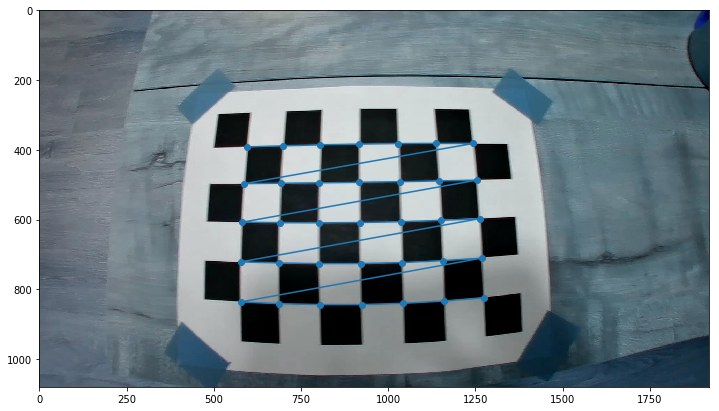

In [4]:
%matplotlib inline

num = 5
objp = calib["objpoints"][0]
    
rvec = calib["rvecs"][num]
tvec = calib["tvecs"][num]
K = calib['K'] 
D = calib['D']

imgp, _ = cv2.fisheye.projectPoints(objp, rvec, tvec, K, D)
img = cv2.imread(imageList[num])

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img)
ax.plot(imgp[:,:,0].flatten(), imgp[:,:,1].flatten(), 'o-', )
fig.show()

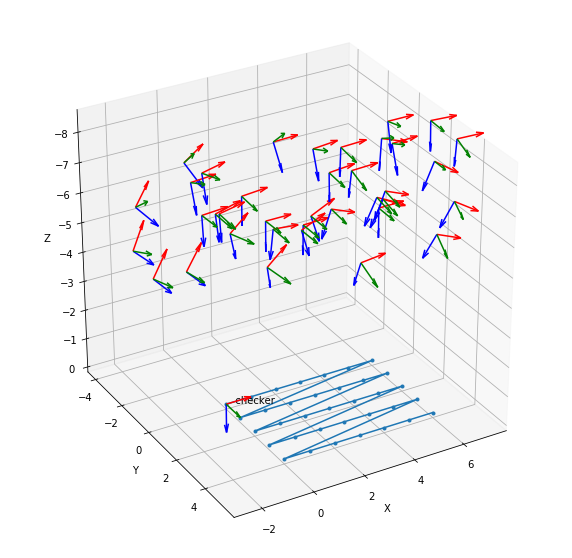

In [5]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

def plot_frame(ax, trans, R, name, length=1):
    trans = trans.reshape(-1)
    ax.quiver(trans[0], trans[1], trans[2], R[0,0], R[1,0], R[2,0], color='r', length=length)
    ax.quiver(trans[0], trans[1], trans[2], R[0,1], R[1,1], R[2,1], color='g', length=length)
    ax.quiver(trans[0], trans[1], trans[2], R[0,2], R[1,2], R[2,2], color='b', length=length)
    ax.text(trans[0], trans[1], trans[2], str("   ")+name, color='black')

squareSize = 1
corners = objp.reshape(-1, 3) * squareSize

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

plot_frame(ax, np.array([[0],[0],[0]]), np.eye(3), "checker")
ax.plot(corners[:,0], corners[:,1], corners[:,2], '.-')

ax.axis('equal')
# ax.set(xlim=(-0.3,0.3), ylim=(-0.3,0.3), zlim=(-0.4,0.2))
ax.view_init(210,-60)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for tvec, rvec in zip(calib["tvecs"], calib["rvecs"]):
    Rvec, _ = cv2.Rodrigues(rvec)
    R = Rvec.T
    tvec = -Rvec.T.dot(tvec * squareSize)

    plot_frame(ax, tvec, R, "", 1)

plt.show()